<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%90%D0%B2%D1%82%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8C%D0%BD%D1%8B%D1%85_%D0%BD%D0%BE%D0%BC%D0%B5%D1%80%D0%BE%D0%B2_%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D0%BD%D0%B0_%D0%BE%D1%81%D0%BD%D0%BE%D0%B2%D0%B5_%D1%80%D0%B5%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D1%85_%D1%81%D0%B8%D0%BC%D0%B2%D0%BE%D0%BB%D0%BE%D0%B2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align: center;"><b>Автоматическое распознавание автомобильных номеров.</b></h1>

<h1 style="text-align: center;"><b>Классификация на основе реальных символов.</b></h1>

Это шестой урок из цикла автоматического распознавания автомобильных номеров ANPR. В этом уроке мы также будем классифицировать вырезанные символы номерного знака. Но для обучения классификатора мы будем использовать не заготовленные изображения шрифтов как в четвёртом уроке, а вырезанные симолы из реальных изображений, которые собрали в предыдущем уроке.

Скачиваем файлы, необходимые для урока, и устанавливаем корневую папку проекта.

In [1]:
!wget http://dataudt.ru/datasets/cv/Lesson_42.ANPR.Classification_real.zip
!unzip -qq Lesson_42.ANPR.Classification_real.zip
%cd /content/Lesson_42.ANPR.Classification_real/

--2022-02-08 06:19:40--  http://dataudt.ru/datasets/cv/Lesson_42.ANPR.Classification_real.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 729769 (713K) [application/zip]
Saving to: ‘Lesson_42.ANPR.Classification_real.zip’

Lesson_42.ANPR.Clas 100%[===================>] 712.67K   831KB/s    in 0.9s    

2022-02-08 06:19:41 (831 KB/s) - ‘Lesson_42.ANPR.Classification_real.zip’ saved [729769/729769]

/content/Lesson_42.ANPR.Classification_real


Скачиваем тестовый датасет для проверки работы алгоритма.

In [2]:
!wget http://dataudt.ru/datasets/cv/license_plate_test_dataset.zip
!unzip -qq license_plate_test_dataset.zip

--2022-02-08 06:19:48--  http://dataudt.ru/datasets/cv/license_plate_test_dataset.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42576480 (41M) [application/zip]
Saving to: ‘license_plate_test_dataset.zip’

license_plate_test_ 100%[===================>]  40.60M  11.8MB/s    in 3.9s    

2022-02-08 06:19:53 (10.3 MB/s) - ‘license_plate_test_dataset.zip’ saved [42576480/42576480]



Импортируем необходимые модули.

In [3]:
# Основные модули.
from sklearn.svm import LinearSVC
from collections import namedtuple
from skimage.filters import threshold_local
from skimage import segmentation
from skimage import measure
from imutils import perspective
import pickle
import glob
import random

import numpy as np
import cv2
import imutils
from imutils.paths import list_images

# Функция для отображения изображений opencv в colab.
from google.colab.patches import cv2_imshow

Для нахождения области с номерным знаком и вырезания символов будем использовать ранее созданный класс LicensePlateDetector. А для получения описательных признаков символов будем использовать BlockBinaryPixelSum. Они уже полностью созданны и не изменились с прошлого урока, поэтому импортируем их из файла.

In [4]:
from anpr.license_plate import LicensePlateDetector
from anpr.descriptors import BlockBinaryPixelSum

В качестве модели классификатора будем использовать метод опорных векторов из библиотеки sklearn. Создадим два классификатора. Один для букв, другой для цифр.

In [5]:
# Укажем папку в которой находяться вырезанные символы, 
# а также путь, где будут храниться обученные классификаторы.

args = {'samples': 'output/examples',                       # вырезанные реальные символы для обучения
        'char-classifier': 'output/simple_char.cpickle',    # классификатор букв
        'digit-classifier': 'output/simple_digit.cpickle',  # класификатор цифр
        'min-samples': 20} # минимальное количество образцов на символ

Обучим классификаторы.

In [6]:
# initialize the descriptor
# инициализируем дескриптор
blockSizes = ((5, 5), (5, 10), (10, 5), (10, 10))
desc = BlockBinaryPixelSum(targetSize=(30, 15), blockSizes=blockSizes)

# initialize the data and labels for the alphabet and digits
# инициализируем данные и метки 
# для алфавита и цифр
alphabetData = []
digitsData = []
alphabetLabels = []
digitsLabels = []

# loop over the sample character paths
# перебираем пути к образцам символов
for samplePath in sorted(glob.glob(args["samples"] + "/*")):
    # extract the sample name, grab all images in the sample path, and sample them
    # извлекаем имя образца,
    # берем все изображения
    # в пути к образцу и используем их
    sampleName = samplePath[-1]

    # список путей к изображениям
    imagePaths = list(list_images(samplePath))
    # используем только заданное случайно выбранное
    # минимальное количество символов
    imagePaths = random.sample(imagePaths, min(len(imagePaths), args["min-samples"]))

	# loop over all images in the sample path
    # перебираем все изображения в пути образца
    for imagePath in imagePaths:
        # load the character, convert it to grayscale, preprocess it, and describe it
        # загрузим символ,
        # преобразуем его в оттенки серого,
        # предобработаем и опишем
        char = cv2.imread(imagePath)
        char = cv2.cvtColor(char, cv2.COLOR_BGR2GRAY)
        char = LicensePlateDetector.preprocessChar(char)
        features = desc.describe(char)

        # check to see if we are examining a digit
        # проверяем, рассматриваем ли мы цифру
        if sampleName.isdigit():
            digitsData.append(features)
            digitsLabels.append(sampleName)

        # otherwise, we are examining an alphabetical character
        # в противном случае мы рассматриваем буквенный символ
        else:
            alphabetData.append(features)
            alphabetLabels.append(sampleName)
          
# train the character classifier
# обучаем классификатор букв
print("[INFO] fitting character model...")
charModel = LinearSVC(C=1.0, random_state=42)
charModel.fit(alphabetData, alphabetLabels)

# train the digit classifier
# обучаем классификатор цифр
print("[INFO] fitting digit model...")
digitModel = LinearSVC(C=1.0, random_state=42)
digitModel.fit(digitsData, digitsLabels)

# dump the character classifier to file
# выгрузим классификатор букв в файл
print("[INFO] dumping character model...")
f = open(args["char-classifier"], "wb")
f.write(pickle.dumps(charModel))
f.close()

# dump the digit classifier to file
# выгрузим классификатор цифр в файл
print("[INFO] dumping digit model...")
f = open(args["digit-classifier"], "wb")
f.write(pickle.dumps(digitModel))
f.close()

[INFO] fitting character model...
[INFO] fitting digit model...
[INFO] dumping character model...
[INFO] dumping digit model...


Загрузим изображения и обученные классификаторы.

In [7]:
# Укажем папку, в которой находятся изображения 
# автомобилей с номерными знаками и классификаторы.
args = {'images': 'license_plate_test_dataset',             # проверочный датасет с изображениями
        'char-classifier': 'output/adv_char.cpickle',    # классификатор букв
        'digit-classifier': 'output/adv_digit.cpickle'}  # класификатор цифр}

# Создадим список изображений в папке.
images_list = sorted(list(list_images(args["images"])))

# Выведем количество изображений в папке.
print('Number of images:', len(images_list))

# load the character and digit classifiers
# загружаем классификаторы символов и цифр
charModel = pickle.loads(open(args["char-classifier"], "rb").read())
digitModel = pickle.loads(open(args["digit-classifier"], "rb").read())

# initialize the descriptor
# инициализируем дескриптор
blockSizes = ((5, 5), (5, 10), (10, 5), (10, 10))
desc = BlockBinaryPixelSum(targetSize=(30, 15), blockSizes=blockSizes)

Number of images: 95


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator LinearSVC from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


Продемонстрируем работу алгоритма.

y_0001.png
Output image


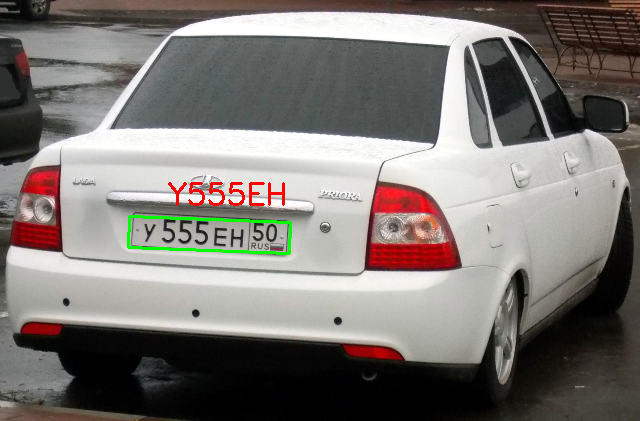

y_0002.png
Output image


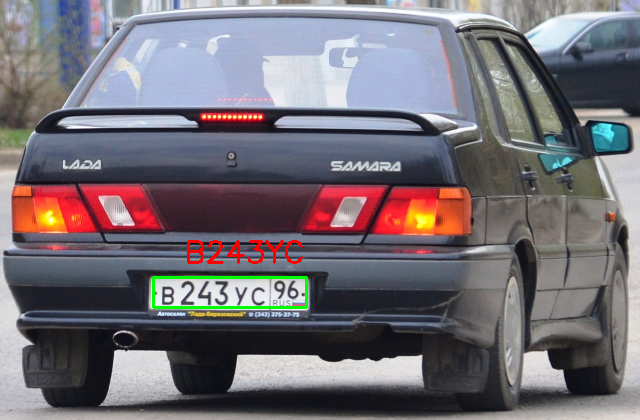

y_0003.png
Output image


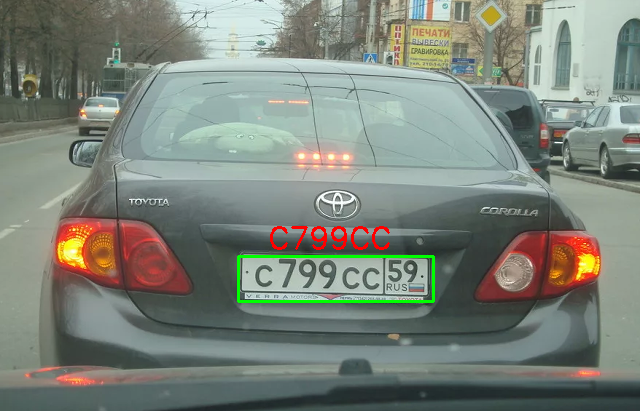

y_0004.png
Output image


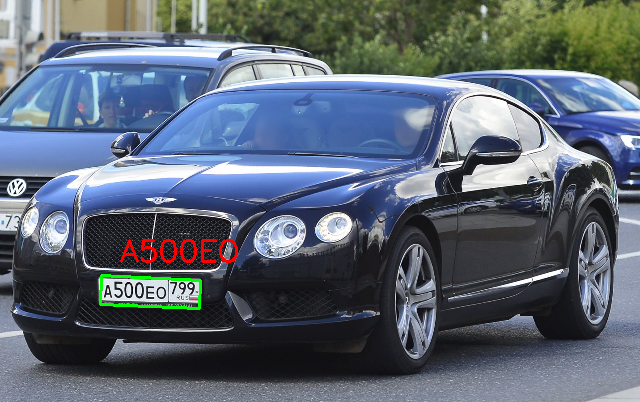

y_0005.png
Output image


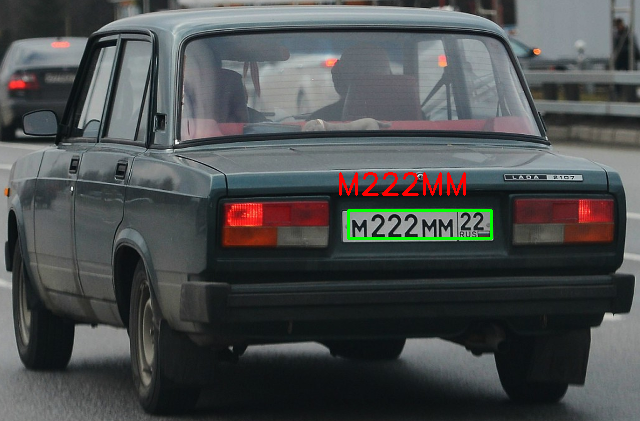

In [8]:
# Сократим список изображений до 5.
# При желании, посмотрите как работает 
# алгоритм на всех изображениях.
images_list = images_list[:5]

# loop over the images
# перебираем изображения
for imagePath in images_list:
    # load the image
    # загрузить изображение
    print(imagePath[imagePath.rfind("/") + 1:]) # только имя
    image = cv2.imread(imagePath)

    # if the width is greater than 640 pixels, then resize the image
    # если ширина изображения больше 640 пикселей,
    # то изменим размер изображения
    if image.shape[1] > 640:
        image = imutils.resize(image, width=640)

    # initialize the license plate detector and detect the license plates and charactors
    # инициализируем детектор номерных знаков 
    # и локализируем номерные знаки и символы
    lpd = LicensePlateDetector(image, numChars=6)
    plates = lpd.detect()

    # loop over the detected plages
    # перебираем обнаруженные фрагменты
    for (lpBox, chars) in plates:
        # restructure lpBox
        # изменяем форму lpBox
        lpBox = np.array(lpBox).reshape((-1, 1, 2)).astype(np.int32)

        # initialize the text containing the recognized characters
        # инициализируем текст, который будет
        # содержать распознанные символы
        text = ""

        # loop over each character
        # перебираем символы
        for (i, char) in enumerate(chars):
            # preprocess the character and describe it
            # обрабатываем символ и описываем его
            char = LicensePlateDetector.preprocessChar(char)
            if char is None:
                continue
            features = desc.describe(char).reshape(1, -1)
            
            # Формат регистрационного номерного знака в РФ
            # состоит из серии и номера.
            # Серия в буквенном виде: в начале 
            # одна буква и в конце две,
            # между ними три цифры номера,
            # и в самом конце номер региона РФ.

            # если сейчас символ серии, то
            # используем классификатор букв
            if i in (1, 2, 3):
                prediction = digitModel.predict(features)[0]
                
            # в противном случае используем классификатор цифр
            else:
                prediction = charModel.predict(features)[0]

            # update the text of recognized characters
            # обновим текст распознанных символов
            text += prediction.upper()

        # compute the center of the license plate bounding box
        # вычисляем центр ограничивающей рамки номерного знака
        M = cv2.moments(lpBox)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        # draw the license plate region and license plate text on the image
        # рисуем регион номерного знака 
        # и текст номерного знака на изображении
        cv2.drawContours(image, [lpBox], -1, (0, 255, 0), 2)
        cv2.putText(image, text, (cX - (cX // 5), cY - 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0,
            (0, 0, 255), 2)

    # display the output image
    # отобразим выходное изображение
    print('Output image')
    cv2_imshow(image)